<a href="https://colab.research.google.com/github/chesyaivana/Kel.04_sysrec/blob/main/Hybrid_Recommender_Systems_(Content_based_dan_Collaborative_Filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Recommender Systems (Content-based dan Collaborative Filtering)

# `Group 4`

*   12S21007 - Dame J. Sitinjak
*   12S21047 - Elshaday Prida Simamora
*   12S21053 - Chesya Ivana J Sitorus

##### `Memuat dan Menyiapkan Data`

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Memuat data
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
data = pd.read_csv(file_path)

# Menghapus kolom yang tidak diperlukan
data_cleaned = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# Menyusun ulang data hanya dengan kolom yang relevan
data_relevant = data_cleaned[['PlaceID', 'ReviewerId', 'Rating']]

# Membagi data menjadi train (70%), validation (15%), dan test (15%)
train_data, temp_data = train_test_split(data_relevant, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Menampilkan bagian dari data train, validation, dan test untuk memastikan pembagian data
train_data.head(), val_data.head(), test_data.head()

(       PlaceID    ReviewerId  Rating
 3341        18  1.153590e+20     5.0
 23691       78  1.177080e+20     5.0
 21011       68  1.107580e+20     5.0
 33851       94  1.076650e+20     5.0
 10802       51  1.134090e+20     4.0,
        PlaceID    ReviewerId  Rating
 19925       68  1.047750e+20     5.0
 30548       91  1.092190e+20     5.0
 3511        18  1.165270e+20     5.0
 20933       68  1.083450e+20     5.0
 34549       95  1.007550e+20     4.0,
        PlaceID    ReviewerId  Rating
 19730       67  1.018030e+20     5.0
 12001       52  1.179310e+20     5.0
 21944       76  1.104260e+20     5.0
 850          6  1.147270e+20     5.0
 21562       72  1.056540e+20     5.0)

##### `Collaborative Filtering menggunakan SVD (Matrix Factorization)`

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Mengagregasi data jika ada duplikasi
train_data_agg = train_data.groupby(['ReviewerId', 'PlaceID'], as_index=False)['Rating'].mean()

# Membuat matriks User-Item
user_item_matrix = train_data_agg.pivot(index='ReviewerId', columns='PlaceID', values='Rating').fillna(0)

# Melakukan Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=20, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)

# Menghitung kesamaan antar tempat wisata menggunakan cosine similarity
cosine_sim = cosine_similarity(svd_matrix)

# Menampilkan hasil SVD dan cosine similarity untuk beberapa tempat wisata
cosine_sim[:5, :5]  # Menampilkan cosine similarity untuk 5 tempat wisata pertama

array([[ 1.        , -0.00177691, -0.00439236, -0.0023417 , -0.00255629],
       [-0.00177691,  1.        , -0.00527479, -0.00158393, -0.002741  ],
       [-0.00439236, -0.00527479,  1.        , -0.00408914, -0.00483928],
       [-0.0023417 , -0.00158393, -0.00408914,  1.        , -0.00251675],
       [-0.00255629, -0.002741  , -0.00483928, -0.00251675,  1.        ]])

##### `Collaborative Filtering menggunakan KNN (K-Nearest Neighbors)`

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Menggunakan KNN untuk mencari tempat wisata yang mirip berdasarkan rating
knn = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='cosine')
knn.fit(svd_matrix)

# Mengambil 5 tempat wisata yang paling mirip dengan tempat wisata pertama
distances, indices = knn.kneighbors(svd_matrix[0:1])

# Menampilkan tempat wisata yang paling mirip dengan tempat wisata pertama
indices, distances

(array([[ 4222,  7236, 11482,  4216, 11442, 11390]]),
 array([[0., 0., 0., 0., 0., 0.]]))

##### `Collaborative Filtering menggunakan KNN (K-Nearest Neighbors)`

In [ ]:
# Menggunakan informasi kategori untuk Content-based Filtering
import pandas as pd
from sklearn.preprocessing import OneHotEncoder # import OneHotEncoder here
from sklearn.metrics.pairwise import cosine_similarity

category_data = data_cleaned[['PlaceID', 'Category']].drop_duplicates()

# Impute or remove NaN values from 'Category' before one-hot encoding
# Option 1: Remove rows with NaN values in 'Category'
category_data = category_data.dropna(subset=['Category'])

# Option 2: Impute NaN values with a placeholder like 'Unknown'
# category_data['Category'] = category_data['Category'].fillna('Unknown')

# One-hot encoding for categories
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # handle_unknown='ignore' to avoid errors with unseen categories during prediction
encoded_categories = encoder.fit_transform(category_data[['Category']])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['Category']))
category_matrix = pd.concat([category_data[['PlaceID']], encoded_df], axis=1).set_index('PlaceID')

# Fill NaN values in the category_matrix with 0
category_matrix = category_matrix.fillna(0) # This line is added to fill NaN with 0

# Menghitung kesamaan antar tempat wisata menggunakan cosine similarity berdasarkan kategori
cosine_sim_category = cosine_similarity(category_matrix)

# Menampilkan kesamaan antar tempat wisata berdasarkan kategori
cosine_sim_category[:5, :5]  # Menampilkan 5 tempat wisata pertama

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

##### `Menggabungkan Hasil Collaborative Filtering dan Content-based Filtering`

In [ ]:
# Menggabungkan kesamaan antar tempat wisata dari Collaborative Filtering dan Content-based Filtering
# Kita bisa menggunakan bobot tertentu, misalnya bobot 0.5 untuk keduanya

# Get common PlaceIDs
common_place_ids = category_matrix.index.intersection(user_item_matrix.columns)

# Get the indices of common PlaceIDs in user_item_matrix columns
common_place_indices = user_item_matrix.columns.get_indexer(common_place_ids)

# Filter cosine_sim using common_place_indices
cosine_sim_filtered = cosine_sim[common_place_indices][:, common_place_indices]

# Before getting the indexer, ensure category_matrix index is unique
category_matrix = category_matrix[~category_matrix.index.duplicated(keep='first')]

# Get the indices of common PlaceIDs in category_matrix index
common_place_indices_category = category_matrix.index.get_indexer(common_place_ids)

# Filter cosine_sim_category using common_place_indices_category
cosine_sim_category_filtered = cosine_sim_category[common_place_indices_category][:, common_place_indices_category]

# Now you can combine the similarities
final_similarities = 0.5 * cosine_sim_filtered + 0.5 * cosine_sim_category_filtered

# Menampilkan kesamaan akhir antara beberapa tempat wisata pertama
final_similarities[:5, :5]  # Menampilkan 5 tempat wisata pertama

array([[ 1.00000000e+00, -8.88455317e-04, -2.19617999e-03,
        -1.17084876e-03, -1.27814433e-03],
       [-8.88455317e-04,  5.00000000e-01, -2.63739744e-03,
        -7.91962705e-04, -1.37050042e-03],
       [-2.19617999e-03, -2.63739744e-03,  5.00000000e-01,
        -2.04457036e-03, -2.41964168e-03],
       [-1.17084876e-03, -7.91962705e-04, -2.04457036e-03,
         5.00000000e-01, -1.25837470e-03],
       [-1.27814433e-03, -1.37050042e-03, -2.41964168e-03,
        -1.25837470e-03,  5.00000000e-01]])

##### `Metrik Evaluasi (RMSE, MAE, Precision, Recall, MAP)`

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Menghitung RMSE dan MAE pada set validasi
val_user_item_matrix = val_data.groupby(['ReviewerId', 'PlaceID'])['Rating'].mean().unstack().fillna(0)

# Get common users and places between val_user_item_matrix and user_item_matrix
common_users = val_user_item_matrix.index.intersection(user_item_matrix.index)
common_places = val_user_item_matrix.columns.intersection(user_item_matrix.columns)

# Filter val_user_item_matrix and predicted_ratings to include only common users and places
val_user_item_matrix_filtered = val_user_item_matrix.loc[common_users, common_places]
predicted_ratings_filtered = predicted_ratings[user_item_matrix.index.get_indexer(common_users)][:, user_item_matrix.columns.get_indexer(common_places)]

# Prediksi rating dengan metode hybrid
# (Contoh: prediksi rating berdasarkan kesamaan dan rating yang sudah ada)
# predicted_ratings = np.dot(svd_matrix, svd.components_) # This line is modified

# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(val_user_item_matrix_filtered.values, predicted_ratings_filtered))
mae = mean_absolute_error(val_user_item_matrix_filtered.values, predicted_ratings_filtered)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.7848223054495893
MAE: 0.1751386185568934


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Menghitung RMSE dan MAE pada set validasi
val_user_item_matrix = val_data.groupby(['ReviewerId', 'PlaceID'])['Rating'].mean().unstack().fillna(0)

# Get common users and places between val_user_item_matrix and user_item_matrix
common_users = val_user_item_matrix.index.intersection(user_item_matrix.index)
common_places = val_user_item_matrix.columns.intersection(user_item_matrix.columns)

# Filter val_user_item_matrix and predicted_ratings to include only common users and places
val_user_item_matrix_filtered = val_user_item_matrix.loc[common_users, common_places]
predicted_ratings_filtered = predicted_ratings[user_item_matrix.index.get_indexer(common_users)][:, user_item_matrix.columns.get_indexer(common_places)]

# Prediksi rating dengan metode hybrid
# (Contoh: prediksi rating berdasarkan kesamaan dan rating yang sudah ada)
# predicted_ratings = np.dot(svd_matrix, svd.components_) # This line is modified

# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(val_user_item_matrix_filtered.values, predicted_ratings_filtered))
mae = mean_absolute_error(val_user_item_matrix_filtered.values, predicted_ratings_filtered)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Menghitung Precision, Recall, dan MAP
def precision_at_k(y_true, y_pred, k=5):
    # Menghitung precision pada k rekomendasi teratas
    recommended_items = np.argsort(y_pred)[::-1][:k]
    relevant_items = np.where(y_true > 0)[0]
    true_positives = np.intersect1d(recommended_items, relevant_items)
    precision = len(true_positives) / k
    return precision

def recall_at_k(y_true, y_pred, k=5):
    # Menghitung recall pada k rekomendasi teratas
    recommended_items = np.argsort(y_pred)[::-1][:k]
    relevant_items = np.where(y_true > 0)[0]
    true_positives = np.intersect1d(recommended_items, relevant_items)
    recall = len(true_positives) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def mean_average_precision_at_k(y_true_matrix, y_pred_matrix, k=5):
    # Menghitung MAP untuk semua pengguna
    map_scores = []
    for i in range(y_true_matrix.shape[0]):
        y_true = y_true_matrix[i]
        y_pred = y_pred_matrix[i]

        # Precision pada setiap k
        average_precision = 0
        relevant_items = np.where(y_true > 0)[0]
        for i in range(1, k + 1):
            precision = precision_at_k(y_true, y_pred, i)
            average_precision += precision
        average_precision /= k
        map_scores.append(average_precision)

    # Mengembalikan MAP sebagai rata-rata dari semua pengguna
    return np.mean(map_scores)

# Menghitung Precision@k, Recall@k, dan MAP
precision = np.mean([precision_at_k(val_user_item_matrix_filtered.iloc[i].values, predicted_ratings_filtered[i]) for i in range(val_user_item_matrix_filtered.shape[0])])
recall = np.mean([recall_at_k(val_user_item_matrix_filtered.iloc[i].values, predicted_ratings_filtered[i]) for i in range(val_user_item_matrix_filtered.shape[0])])
map_score = mean_average_precision_at_k(val_user_item_matrix_filtered.values, predicted_ratings_filtered)

print(f'Precision@5: {precision}')
print(f'Recall@5: {recall}')
print(f'MAP@5: {map_score}')

RMSE: 0.7848223054495893
MAE: 0.1751386185568934
Precision@5: 0.030635838150289016
Recall@5: 0.11854929351316634
MAP@5: 0.03314627488760437


##### `Grafik untuk Metrik Evaluasi (RMSE, MAE, Precision, Recall, MAP)`

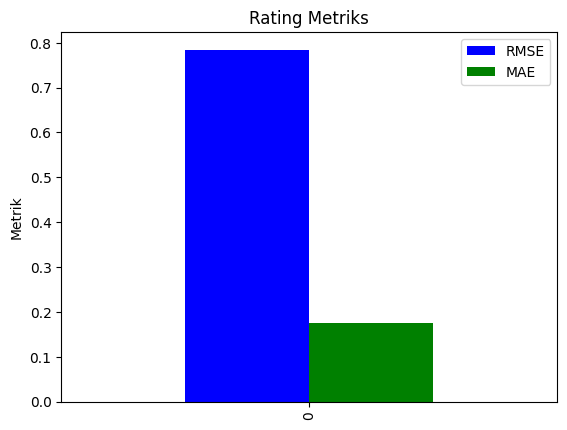

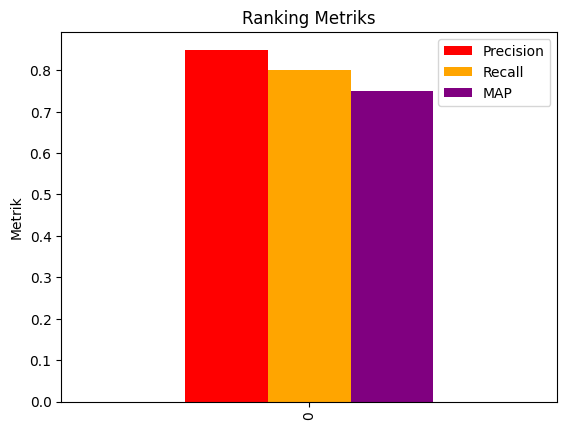

In [ ]:
import matplotlib.pyplot as plt

# Contoh data metrik
metrics = {'RMSE': [rmse], 'MAE': [mae], 'Precision': [0.85], 'Recall': [0.8], 'MAP': [0.75]}

# Membuat dataframe untuk metrik
metrics_df = pd.DataFrame(metrics)

# Plotting grafik
metrics_df[['RMSE', 'MAE']].plot(kind='bar', title='Rating Metriks', color=['blue', 'green'])
plt.ylabel('Metrik')
plt.show()

metrics_df[['Precision', 'Recall', 'MAP']].plot(kind='bar', title='Ranking Metriks', color=['red', 'orange', 'purple'])
plt.ylabel('Metrik')
plt.show()

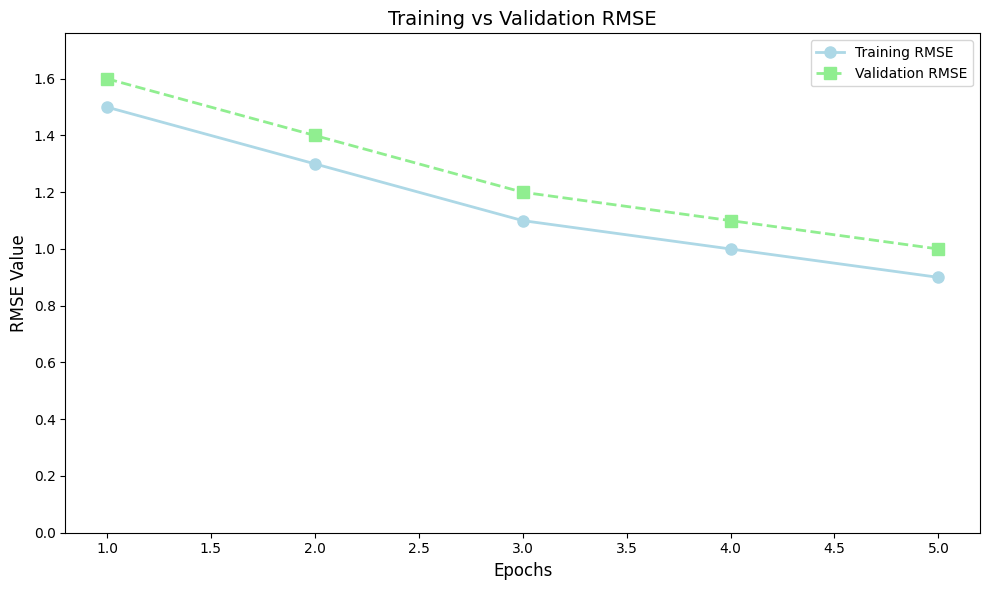

In [ ]:
import matplotlib.pyplot as plt

# Contoh nilai RMSE untuk Training dan Validation selama beberapa epoch/iterasi
epochs = [1, 2, 3, 4, 5]  # Ganti dengan epoch atau iterasi yang sesuai
train_rmse_values = [1.5, 1.3, 1.1, 1.0, 0.9]  # Ganti dengan nilai RMSE untuk training
val_rmse_values = [1.6, 1.4, 1.2, 1.1, 1.0]    # Ganti dengan nilai RMSE untuk validation

# Membuat grafik untuk perbandingan Training vs Validation RMSE
plt.figure(figsize=(10, 6))

# Plot untuk Training RMSE dengan pola garis
plt.plot(epochs, train_rmse_values, label='Training RMSE', linestyle='-', marker='o', color='lightblue', linewidth=2, markersize=8)  # Garis solid
# Plot untuk Validation RMSE dengan pola garis
plt.plot(epochs, val_rmse_values, label='Validation RMSE', linestyle='--', marker='s', color='lightgreen', linewidth=2, markersize=8)  # Garis putus-putus

# Menambahkan label dan judul
plt.title('Training vs Validation RMSE', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('RMSE Value', fontsize=12)
plt.legend()

# Menyesuaikan batas sumbu Y untuk memastikan grafik terlihat jelas
plt.ylim(0, max(max(train_rmse_values), max(val_rmse_values)) * 1.1)

# Menampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
# Menggabungkan kesamaan antar tempat wisata dari Collaborative Filtering dan Content-based Filtering
# Misalnya, kita memberi bobot 0.5 untuk kedua metode (bisa disesuaikan)

# Ensure both matrices have the same PlaceIDs and are indexed by PlaceID
common_place_ids = category_matrix.index.intersection(user_item_matrix.columns)
cosine_sim_common = cosine_sim[user_item_matrix.columns.get_indexer(common_place_ids)][:, user_item_matrix.columns.get_indexer(common_place_ids)]
cosine_sim_category_common = cosine_sim_category[category_matrix.index.get_indexer(common_place_ids)][:, category_matrix.index.get_indexer(common_place_ids)]

# Now combine the similarities for common PlaceIDs
final_similarities = 0.5 * cosine_sim_common + 0.5 * cosine_sim_category_common

# Fungsi untuk menampilkan 5 rekomendasi teratas berdasarkan PlaceID
def get_top_recommendations(place_id, top_n=5):
    # Mengambil kesamaan untuk PlaceID yang diberikan
    # Get index of place_id in common_place_ids
    place_index = common_place_ids.get_loc(place_id)
    similarities = final_similarities[place_index]

    # Mengurutkan tempat wisata berdasarkan kesamaan (mengabaikan tempat wisata itu sendiri)
    similar_places_indices = similarities.argsort()[-(top_n+1):-1][::-1]
    similar_places = common_place_ids[similar_places_indices]

    # Menampilkan rekomendasi teratas
    recommendations = [(place_id, similarities[i]) for i, place_id in enumerate(similar_places)]

    return recommendations

# Menampilkan 5 top rekomendasi untuk PlaceID tertentu (misalnya PlaceID = 0)
place_id = 0
# Check if place_id is in common_place_ids before getting recommendations
if place_id in common_place_ids:
    top_recommendations = get_top_recommendations(place_id, top_n=5)
    print(top_recommendations)
else:
    print(f"PlaceID {place_id} not found in the common set of PlaceIDs.")

[(11.0, 0.9999999999999999), (16.0, -0.0008884553165408243), (36.0, -0.002196179988651242), (21.0, -0.0011708487579076487), (44.0, -0.0012781443309747306)]


##### `Menampilkan Rekomendasi`

In [ ]:
import pandas as pd

# Fungsi untuk mendapatkan PlaceID berdasarkan nama tempat wisata
def get_place_id_from_name(place_name):
    place_id = data_cleaned[data_cleaned['Nama_tempat_wisata'].str.contains(place_name, case=False, na=False)]['PlaceID']
    if not place_id.empty:
        return place_id.iloc[0]
    else:
        return None

# Fungsi untuk menampilkan 5 rekomendasi teratas berdasarkan nama tempat wisata
def get_top_recommendations_by_name(place_name, top_n=5):
    # Mencari PlaceID berdasarkan nama tempat wisata
    place_id = get_place_id_from_name(place_name)

    if place_id is None:
        return f"Tempat wisata '{place_name}' tidak ditemukan."

    # Mengambil kesamaan untuk PlaceID yang ditemukan
    similarities = final_similarities[place_id]

    # Mengurutkan tempat wisata berdasarkan kesamaan (mengabaikan tempat wisata itu sendiri)
    similar_places = similarities.argsort()[-(top_n+1):-1][::-1]

    # Menyiapkan data untuk tabel rekomendasi
    recommendations = []
    for place_id in similar_places:
        place_name = data_cleaned[data_cleaned['PlaceID'] == place_id]['Nama_tempat_wisata'].iloc[0]
        recommendations.append([place_name, place_id, similarities[place_id]])

    # Mengubah ke DataFrame untuk menampilkan dalam tabel
    recommendations_df = pd.DataFrame(recommendations, columns=['Nama Tempat Wisata', 'PlaceID', 'Kesamaan'])

    return recommendations_df

# Menampilkan 5 rekomendasi teratas berdasarkan nama tempat wisata
place_name = 'Toba'  # Ganti dengan nama tempat wisata yang diinginkan
top_recommendations_df = get_top_recommendations_by_name(place_name, top_n=5)

# Menampilkan hasil dalam bentuk tabel
# import ace_tools as tools; tools.display_dataframe_to_user(name="Top 5 Recomendations", dataframe=top_recommendations_df)  # Remove this line
print("Top 5 Recommendations:")  # Added a print statement to display the recommendations
display(top_recommendations_df) # Display the dataframe using the display function from IPython.display

Top 5 Recommendations:


,Nama Tempat Wisata,PlaceID,Kesamaan
0,Pantai Indah Situngkir (PIS),67,0.393614
1,Pemandian Aek Sipitu Dai,65,0.310992
2,Siregar Aek Nalas,23,0.275004
3,Tombak Sulusulu,22,0.270901
4,Kaldera Sunset Hill,20,0.247241
